In [4]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy
from scipy.interpolate import PchipInterpolator as PI
from scipy.interpolate import CubicSpline as CS
from scipy.interpolate import interp1d as i1d
import pickle
from scipy import integrate
import time
from joblib import Parallel, delayed
import numba

machine parameters & RF settings

In [30]:
c=scipy.constants.c
m_e=0.511e+6

sigma_delta=1.06e-3#relative energy spread, 
eta=1.56e-5 # slip factor
E_0=6e+9 #nominal energy
C=1360.4 #circumference
T_0=C/c # revolution period
omega_0=2*np.pi/T_0 #syncrotron frequncy
gamma=E_0/m_e#lorentz factor
beta=np.sqrt(1-1/gamma**2)
omega_beta=106.27*omega_0 # nu_y*omega_0


#main cavity: harmonic number,wave number,synch-phase,voltage
h1=756
k_1=2*np.pi*h1/C#f1
phi_s1=2.918
V1=8.298e+5
#harmonic cavity: harmonic ratio, wave number,synch-phase,voltage, voltage ratiao

h_r=3
k_2=h_r*k_1
phi_s2=5.588
V2=2.875e+5
h2=h_r*h1
r_r=V2/V1

#SR energy loss, default RF setting is set to ensure SR loss is compensated by the RF
U_0=V1*np.sin(phi_s1)+V2*np.sin(phi_s2)

mu=-1/(eta*sigma_delta**2)

#discretisation of positon 'z'
m_hs=2000
n_hs=2*m_hs+1
q_boundary=0.15#m
h=q_boundary/m_hs
q=np.zeros((n_hs,1))
for i in range(0, n_hs):
    q[i]=-q_boundary+i*h
q_itp=np.linspace(-q_boundary,q_boundary,n_hs)


#potential well dominated by the double RF system
V_PW0=V1/(2*np.pi*h1*E_0)*(np.cos(phi_s1-k_1*q)+r_r/h_r*np.cos(phi_s2-k_2*q)-k_1*q*(np.sin(phi_s1)+r_r*np.sin(phi_s2))-np.cos(phi_s1)-r_r/h_r*np.cos(phi_s2))
V_PW=V_PW0.T[0]
min_ind=np.where(V_PW==np.min(V_PW))[0][0]

func_PW=CS(q_itp,V_PW)

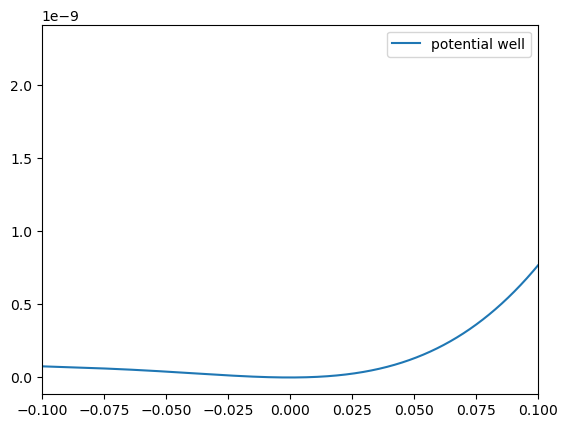

In [32]:
plt.plot(q,V_PW,label='potential well')
#plt.scatter(q_min_K,K_dis_a)
plt.xlim([-0.1,0.1])
#plt.ylim([-1e-11,1e-10])
plt.legend()
plt.show()

find limits of integration of canonical trans formation:qmin qmax 

In [37]:
def density_func(x):
    return np.exp(mu*func_PW(x))

norm_fac=scipy.integrate.quad(density_func,-q_boundary,q_boundary)[0]

def g_func(K):
    return np.exp(mu*K)/np.sqrt(2*np.pi)/norm_fac

an=integrate.quad(g_func,np.min(V_PW),1.2e-10)[0]
sum=integrate.quad(g_func,np.min(V_PW),2e-10)[0]
print(an/sum)#make sure that >99.75% density is envoloved in the calculation 

0.998947502594817


In [39]:
SFPdifine=np.shape(scipy.signal.find_peaks(V_PW)[0])[0]#find number of SFPs
#divide the potential well into two different parts，solve the particular Limits of each Hamitonian
def find(q,K,lowbnd,upbnd,turn):
    def func_K(q_1,K_1):
        return func_PW(q_1)-K_1
    K_1=K
    q_min=scipy.optimize.bisect(func_K,q[lowbnd],q[turn],xtol=1e-25,args=(K_1),maxiter=10000)
    q_max=scipy.optimize.bisect(func_K,q[turn],q[upbnd],xtol=1e-25,args=(K_1),maxiter=10000)
    return q_min,q_max
    
def discrete1(n1,min,max):
    q_min1,q_max1=find(q,min,0,-1,min_ind)
    q_min2,q_max2=find(q,max,0,-1,min_ind)
    q_disc=np.linspace(q_min1,q_min2,n1)
    K_dis=func_PW(q_disc)
    return K_dis
def discrete2(n1,min,max):
    q_min1,q_max1=find(q,min,0,-1,min_ind)
    q_min2,q_max2=find(q,max,0,-1,min_ind)
    q_disc=np.linspace(q_max1,q_max2,n1)
    K_dis=func_PW(q_disc)
    return K_dis

if SFPdifine!=0:
    peak=scipy.signal.find_peaks(V_PW)[0][0]
    sfp_2=scipy.signal.find_peaks(-V_PW)[0][-1]#the second lowest PW
    sfp_1=scipy.signal.find_peaks(-V_PW)[0][0]#the lowest PW

def sec3(K_dis_num1,K_dis_num2,K_dis_num3, Kmax):
    Kmin1=V_PW[sfp_1]
    Kmin2=V_PW[sfp_2]
    Ktrn=V_PW[peak]
    D1=(Ktrn-Kmin1)/K_dis_num1*0.01
    D2=(Ktrn-Kmin2)/K_dis_num2*0.01
    D3=(Kmax-Ktrn)/K_dis_num3*0.01
    K_dis3=discrete1(K_dis_num3,Ktrn+D3,Kmax)
   
    q_min_K1=np.zeros(K_dis_num1)
    q_max_K1=np.zeros(K_dis_num1)
    q_min_K2=np.zeros(K_dis_num2)
    q_max_K2=np.zeros(K_dis_num2)
    q_min_K3=np.zeros(K_dis_num3)
    q_max_K3=np.zeros(K_dis_num3)
    
    if sfp_1<sfp_2:
        q_dis1=np.linspace(q_itp[sfp_1],q_itp[peak],K_dis_num1)
        K_dis1=func_PW(q_dis1)
        K_dis1[0]=K_dis1[0]+D1
        K_dis1[-1]=K_dis1[-1]-D1
        q_dis2=np.linspace(q_itp[sfp_2],q_itp[peak],K_dis_num2)
        K_dis2=func_PW(q_dis2)
        K_dis2[0]=K_dis2[0]+D2
        K_dis2[-1]=K_dis2[-1]-D2
        for i in range(0,K_dis_num1):
            q_min_K1[i],q_max_K1[i]=find(q,K_dis1[i],0,peak,sfp_1) 
        for i in range(0,K_dis_num2):
            q_min_K2[i],q_max_K2[i]=find(q,K_dis2[i],peak,-1,sfp_2) 
    if sfp_1>sfp_2:
        q_dis1=np.linspace(q_itp[sfp_1],q_itp[peak],K_dis_num1)
        K_dis1=func_PW(q_dis1)
        q_dis2=np.linspace(q_itp[sfp_2],q_itp[peak],K_dis_num2)
        K_dis2=func_PW(q_dis2)
        for i in range(0,K_dis_num1):
            q_min_K1[i],q_max_K1[i]=find(q,K_dis1[i],peak,-1,sfp_1) 
        for i in range(0,K_dis_num2):
            q_min_K2[i],q_max_K2[i]=find(q,K_dis2[i],0,peak,sfp_2) 
    for i in range(0,K_dis_num3):
        q_min_K3[i],q_max_K3[i]=find(q,K_dis3[i],0,-1,min_ind) 
    K_dis_in=np.hstack((K_dis1,K_dis2,K_dis3))


    q_min_K_in=np.hstack((q_min_K1,q_min_K2,q_min_K3))
    q_max_K_in=np.hstack((q_max_K1,q_max_K2,q_max_K3))
    
    K_dis_num_in=np.shape(K_dis_in)[0]
    return q_min_K_in,q_max_K_in,K_dis_in,K_dis_num_in,K_dis_num1,K_dis_num2,K_dis_num3


In [41]:
if SFPdifine!=0:
    q_min_K,q_max_K,K_dis_a,K_dis_numa,action_num1,action_num2,action_num3=sec3(100,100,100,1e-10)#K_dis_num1,K_dis_num2,K_dis_num3, Kmax
    
if SFPdifine==0:
    roK=1.2e-10#range of Hamitonian
    Kmax=np.min(V_PW)+roK#Hamitonian cutoff
    Kmin=np.min(V_PW)+roK*1e-8

    K_dis_a=discrete1(100,Kmin,Kmax)# number of discretization
    K_dis_numa=K_dis_a.shape[0]
    q_min_K=np.zeros(K_dis_numa)
    q_max_K=np.zeros(K_dis_numa)
    for i in range(0,K_dis_numa):
        q_min_K[i],q_max_K[i]=find(q,K_dis_a[i],0,-1,min_ind) 
    action_num1=K_dis_numa
    action_num2=0
    action_num3=0

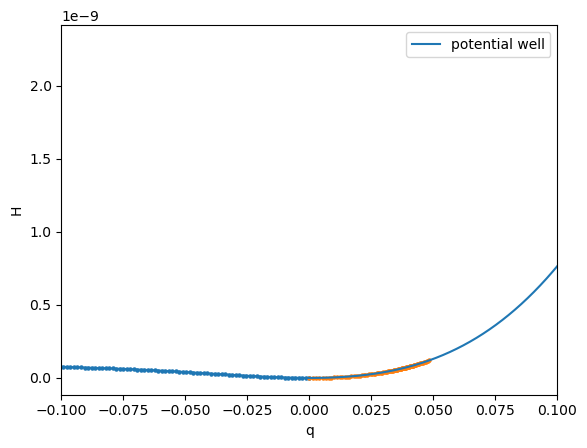

In [43]:
#sample of the limits of integration
plt.plot(q,V_PW,label='potential well')
plt.xlim([-0.1,0.1])
#plt.ylim([-5e-12,5e-11])
plt.scatter(q_min_K,K_dis_a,s=5)
plt.scatter(q_max_K,K_dis_a,s=5)
plt.xlabel('q')
plt.ylabel('H')
plt.legend()
plt.show()

In [45]:
def omega(q_min,q_max,H):#calculate synchrotron frequncey
    def func_omega(q):
        return 1/np.sqrt(np.abs(-2*(H+func_PW(q))/eta))/eta
    a=np.pi/integrate.quad(func_omega,q_min,q_max)[0]
    return a

def ompar(i):
    return omega(q_min_K[i],q_max_K[i],-np.max(func_PW([q_min_K[i],q_max_K[i]])))

start=time.time()
omega_results = Parallel(n_jobs=20)(delayed(ompar)(i) for i in range(0,K_dis_numa) )
end=time.time()
print(end-start)

freq_pwd=np.zeros(K_dis_numa)
for i in range(0,K_dis_numa):
    freq_pwd[i]=omega_results[i]#dH/dJ

0.8028266429901123


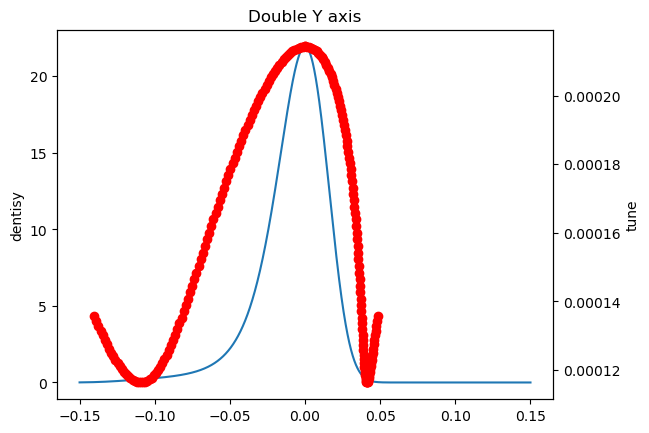

In [49]:
dstr=np.exp(mu*V_PW)/np.sum(np.exp(mu*V_PW))/h#noramalised density
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(q,dstr)
ax1.set_ylabel('dentisy')
ax1.set_title("Double Y axis")
ax2 = ax1.twinx()  
ax2.scatter(q_min_K,freq_pwd*C/2/np.pi, c='r')
ax2.scatter(q_max_K,freq_pwd*C/2/np.pi, c='r')
ax2.set_ylabel('tune')
ax2.set_xlabel('aa')
#ax2.set_ylim([0.0007401,0.0007406])
plt.show()

phase space sampling

In [58]:
para_for_sample=200#number of sampling points

A1,B1=q_min_K,q_max_K#limits of integration
def sample(maxM,minM):
    qtes=np.zeros((np.shape(maxM)[0],para_for_sample+1))
    for i in range(0,para_for_sample+1):
        r=(maxM-minM)/2
        qtes[:,i]=maxM/2+minM/2+r*np.cos(i*np.pi/para_for_sample)
    return qtes  

qa=sample(B1,A1)
#generating function，calcalate angle variable:lower limits of integration，upper limits of integration，Hamitonian,synchrotron frequncy
def generating_func(q_lower,q_upper,H,omega):
    def func_J(q):
        return -omega/np.emath.sqrt(np.abs(-2*(H+func_PW(q))/eta))/eta
    a=integrate.quad(func_J,q_lower,q_upper)[0]
    return a


def angle_position(cnt):#parallel calculation
    angle0=np.zeros(para_for_sample+1)
    for i in range(1,para_for_sample+1):
        angle0[i]=generating_func(B1[cnt],qa[cnt,i],-K_dis_a[cnt],freq_pwd[cnt])
    angle0[0]=0 
    return angle0   

Text(0, 0.5, 'p')

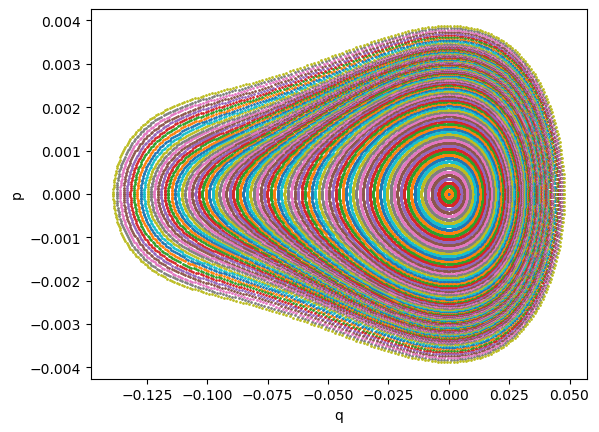

In [62]:
#plot the phase space sampling results
def sample2(i,q):
    A=np.zeros(q.shape[0])
    A=np.emath.sqrt(2*np.abs(-K_dis_a[i]+func_PW(q))/eta)
    return A
for i in range(0,99):
    plt.scatter(np.hstack((qa[i],qa[i])), np.hstack((-sample2(i,qa[i]),sample2(i,qa[i]))),s=1)
plt.xlabel('q')
plt.ylabel('p')

In [64]:
#calculate angule variable
start=time.time()
angle_results = Parallel(n_jobs=20)(delayed(angle_position)(i) for i in range(0,K_dis_numa) )
angle=angle_results[0]
for i in range(1,K_dis_numa):
    angle=np.vstack((angle,angle_results[i]))
end=time.time()
print(end-start)

mat_CT=np.stack((angle,qa))

7.811109781265259


In [66]:
#density matrix
densM=g_func(K_dis_a)/sigma_delta

Text(0, 0.5, 'density coefficient')

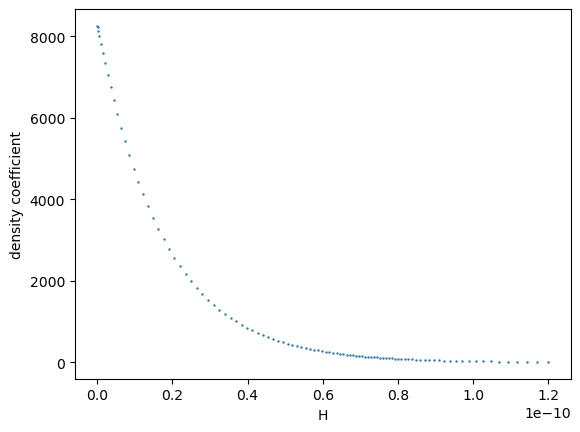

In [70]:
plt.scatter(K_dis_a,densM,s=0.5)
plt.xlabel('H')
plt.ylabel('density coefficient')

In [72]:
#calculate action variable:lower limits of integration，upper limits of integration，Hamitonian

def action(q_min,q_max,H):
    def func_ac(q):
        return np.sqrt(-2*(-H+func_PW(q))/eta)
    a=integrate.quad(func_ac,q_min,q_max)[0]/np.pi
    return a

def acpar(i):
    return action(q_min_K[i],q_max_K[i],K_dis_a[i])


start=time.time()
action_results = Parallel(n_jobs=20)(delayed(acpar)(i) for i in range(0,K_dis_numa) )#角向模数
end=time.time()
print(end-start)


action_fin1=np.zeros(action_num1)
action_fin2=np.zeros(action_num2)
action_fin3=np.zeros(action_num3)
for i in range(0,action_num1):
    action_fin1[i]=action_results[i]
dJ1=np.hstack((action_results[0],np.diff(action_fin1)))
if action_num2>0:
    for i in range(0,action_num2):
        action_fin2[i]=action_results[action_num1+i]
    dJ2=np.hstack((action_results[action_num1],np.diff(action_fin2)))
if action_num2==0:
    dJ2=np.array([])
if action_num3>0:    
    for i in range(0,action_num3):
        action_fin3[i]=action_results[i+action_num1+action_num2]
    dJ3=np.hstack(((action_results[action_num1+action_num2]-action_results[action_num1+action_num2-1]),np.diff(action_fin3)))
if action_num3==0:
    dJ3=np.array([])



dJ=np.hstack((dJ1,dJ2,dJ3))

0.06677675247192383


In [74]:
imp_read=pickle.load(open(r'E:\impedance\TMCI', 'rb'))
imp=imp_read[1,:]
q_imp=imp_read[0,:].real
func_imp=CS(q_imp,imp)

(-10000000.0, 10000000.0)

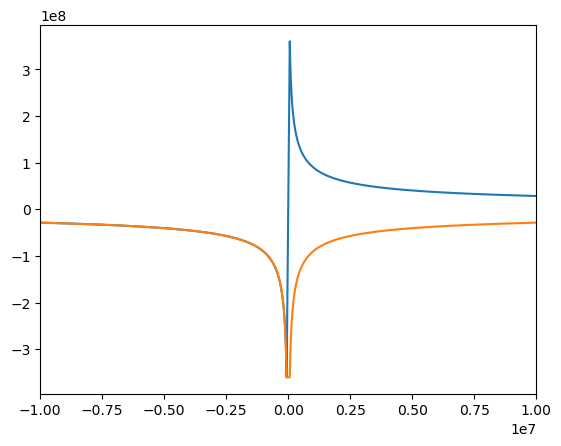

In [76]:
plt.plot(q_imp,imp.real)
plt.plot(q_imp,imp.imag)
plt.xlim([-1e+7,1e+7])

In [78]:
n_rad=mat_CT.shape[1]#number of radial(Hamitonian) discretization
n_azi=3#number of azimuthal modes
n_mat=(2*n_azi+1)*n_rad#

k_lim=1e+12# frequency limit
n_disc=2000#frequency discretization

freq0=np.hstack((-np.flipud(np.logspace(-1,np.log10(k_lim),n_disc)[1:]),np.logspace(-1,np.log10(k_lim),n_disc)))#从0开始的频域
freq=np.atleast_2d(freq0)
freqh=freq.T

M_ipdc=func_imp(freq)#impedance

q_angle=mat_CT[1]#position of sampling points
phi=mat_CT[0]#angle variable of sampling points

$2\xi\omega_{\beta}\hat{z}/\eta c$

In [81]:
xi=0.0000#chromaticity
#spectrun function
def func_h(l,i):
    y=np.cos(l*phi[i,:])*np.exp(-1j*q_angle[i,:]/c*(freqh-xi*omega_beta/eta))
    return scipy.integrate.trapezoid(y,x=phi[i,:],axis=-1)/(np.pi)

start=time.time()
results_0 = Parallel(n_jobs=20)(delayed(func_h)(a,b) for a in range(-n_azi,n_azi+1) for b in range(0,n_rad)  )
end=time.time()
print(end-start)

6.140976667404175


In [87]:
Mat_g=1j*np.zeros((2*n_azi+1,n_rad,2*n_disc-1))
for l in range(-n_azi,n_azi+1):
    for i in range(0,n_rad):
        Mat_g[l+n_azi,i]=results_0[(l+n_azi)*n_rad+i]

In [89]:
def integ_M_azi(l,m):#the l，m-th azimuthal modes
    M1=1j*np.zeros((n_rad,n_rad))
    for i in range(0,n_rad):
        for j in range(0,n_rad):
            y=M_ipdc*np.conj(Mat_g[l+n_azi,i])*Mat_g[m+n_azi,j]
            M1[i,j]=scipy.integrate.trapezoid(y,x=freq,axis=-1)#对频率积分
    return M1

start=time.time()
results1 = Parallel(n_jobs=20)(delayed(integ_M_azi)(a,b) for a in range(-n_azi,n_azi+1) for b in range(-n_azi,n_azi+1)  )
end=time.time()
print(end-start)

2.8114778995513916


In [90]:
#rearrange the matrix of parallel calculation

td1=1j*np.ones((2*n_azi+1,2*n_azi+1,n_rad,n_rad))
for i in range(0,(2*n_azi+1)*(1+2*n_azi)):
    td1[i//(2*n_azi+1),i%(2*n_azi+1)]=results1[i]

In [91]:
#rearrange the matrix
def re_():
    M1=1j*np.zeros((n_mat,n_mat))
    for l in range(-n_azi,n_azi+1):
        for m in range(-n_azi,n_azi+1):
            for i in range(0,n_rad):
                for j in range(0,n_rad):
                    M1[n_rad*(l+n_azi)+i,n_rad*(m+n_azi)+j]=td1[(l+n_azi),(m+n_azi),i,j]  
    return M1
Mat_S=re_() 

In [101]:
#eigenvalue problem
def func1():
    A=np.zeros((n_mat,n_mat))
    B=1j*np.zeros((n_mat,n_mat))
    for l in range(-n_azi,n_azi+1):
        for m in range(-n_azi,n_azi+1):
            for i in range(0,n_rad):
                for j in range(0,n_rad):
                    B[n_rad*(l+n_azi)+i,n_rad*(m+n_azi)+j]=1j*c/(2*E_0*omega_beta*T_0)*dJ[j]*densM[i]*Mat_S[n_rad*(l+n_azi)+i,n_rad*(m+n_azi)+j]
                    if l==m:
                        if i==j:
                            A[n_rad*(l+n_azi)+i,n_rad*(m+n_azi)+j]=l*freq_pwd[i]*c
    return A,B
def func_azi(l):
    m=l
    A=1j*np.zeros((n_rad,n_rad))
    B=1j*np.zeros((n_rad,n_rad))
    for i in range(0,n_rad):
        for j in range(0,n_rad):
            A[i,j]=l*freq_pwd[i]*c        
            B[i,j]=1j*c/(2*E_0*omega_beta*T_0)*dJ[j]*densM[i]*Mat_S[n_rad*(l+n_azi)+i,n_rad*(m+n_azi)+j]
    return A,B

In [105]:
#final matrix
A0,B0=func1()

In [107]:
start=time.time()
cnt=21# number of charge case
maxima=2e-9# max charge [C]
mat_Charge=np.linspace(0,maxima,cnt)
e_M=1j*np.zeros(n_mat)
for i in range(0,cnt):
    X=A0-mat_Charge[i]*B0
    e=np.linalg.eigvals(X)
    e_M=np.vstack((e_M,e))
end=time.time()
print(end-start)

10.965811014175415


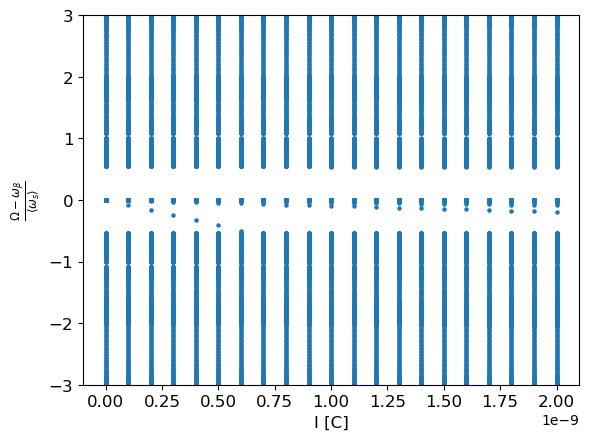

In [108]:
freq_real=np.atleast_2d(e_M[1:].real).T
freq_imag=np.atleast_2d(e_M[1:].imag).T

plt.scatter(np.ones((n_mat,1))*mat_Charge,freq_real/296.72411684,s=5)
plt.xlabel('I [C]',fontsize=12)
#plt.scatter((np.ones((n_mat,1))*mat_Charge)[index_plot],freq_real[index_plot],s=1)
plt.ylabel(r'$\frac{\Omega-\omega_{\beta}}{\langle\omega_s\rangle}$',fontsize=12)
plt.ylim([-3,3])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

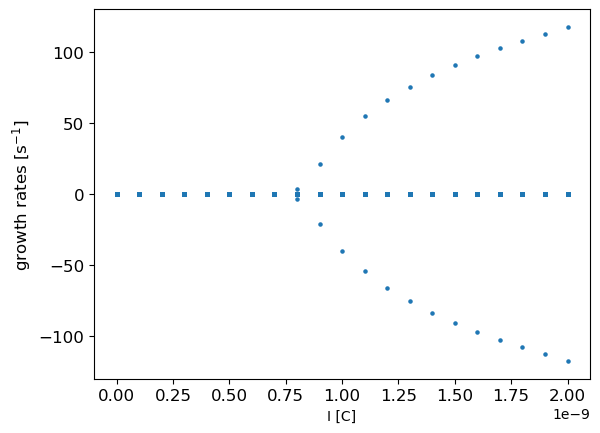

In [109]:
plt.scatter(np.ones((n_mat,1))*mat_Charge,freq_imag,s=5)
#plt.scatter((np.ones((n_mat,1))*mat_Charge)[index_plot],freq_imag[index_plot],s=1)
plt.ylim([-130,130])
plt.xlabel('I [C]')

#plt.scatter((np.ones((n_mat,1))*mat_Charge)[index_plot],freq_real[index_plot],s=1)
plt.ylabel('growth rates [s'r'$^{-1}$'']',fontsize=12)
plt.ylim([-130,130])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()